![](../img/330-banner.png)

# Tutorial 4

UBC 2024-25

## Outline

During this tutorial, you will try hyperparameter optimization with `GridSearchCV` and `RandomizedSearchCV`, to find the best hyperparameters to perform a classification task using SVM RBF.

All questions can be discussed with your classmates and the TAs - this is not a graded exercise!

In [17]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
pd.set_option("display.max_colwidth", 200)
DATA_DIR = "../data/"

The goal of this classification problem is to predict which songs the user likes (target = 1) and which one they will not like (target = 0) based on some songs characteristics, like tempo and danceability.

You have seen this dataset before (HW2), but take a moment to review its columns. You can also review the [source](https://www.kaggle.com/datasets/geomack/spotifyclassification). 

In [18]:
spotify_df = pd.read_csv(DATA_DIR + "spotify.csv", index_col=0)
spotify_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [19]:
# Separating features and target 
# We are also removing the artist column for this exercise

X_spotify = spotify_df.drop(columns=["target", "artist"])
y_spotify = spotify_df["target"]

# Creating training and test set

X_train, X_test, y_train, y_test = train_test_split(
    X_spotify, y_spotify, test_size=0.2, random_state=123
)

This dataset includes various types of features, so we will need to preprocess them before we are able to use them. The `ColumnTransformer` to do this is provided to you.

In [20]:
numeric_feats = ['acousticness', 'danceability', 'energy',
                 'instrumentalness', 'liveness', 'loudness',
                 'speechiness', 'tempo', 'valence'] # Scaling
categorical_feats = ['time_signature', 'key'] # OHE
passthrough_feats = ['mode']
text_feat = "song_title" # Text processing (Bag of Words with CountVectorizer)

In [21]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats), 
    (OneHotEncoder(handle_unknown = "ignore"), categorical_feats), 
    ("passthrough", passthrough_feats), 
    (CountVectorizer(max_features=50, stop_words="english"), text_feat)
)

For this tutorial, we will focus on tuning a SVM RBF model. Other models may perform better, so typically we would not want to limit us to a single model without trying them out, but this will be enough to practice hyperparameter tuning.

Run the next line to put the preprocessor and the `SVC` model in a pipeline

In [22]:
pipe_svm = make_pipeline(preprocessor, SVC())

### <font color='red'>Question 1</font>

To have a base line to compare the improvements caused by hyperparameter tuning, let's first try the "off the shelf" model, the one with default parameters, and see what scores we get. 

By the way, the default values of C and gamma are `C = 1` and `gamma='scale'`, as visible on the [SVC documentation](https://scikit-learn.org/1.6/modules/generated/sklearn.svm.SVC.html). `gamma='scale'` corresponds to a value of 1 / (n_features * X.var()), a robust default value (you can see Mike Gelbart, one of the course designers, arguing for it in this conversation in a [scikit-learn Github](https://github.com/scikit-learn/scikit-learn/issues/12741) issue).

Use cross validation to see what the performance of our model is before we try to improve it. Reflect on the results: does it look like the model is good, or do we see signs of overfitting/underfitting?

In [57]:
scores = cross_validate(pipe_svm, X_train, y_train, cv=10, return_train_score=True)

cv_scores_df = pd.DataFrame(scores)
mean_scores = cv_scores_df.mean()
mean_scores

fit_time       0.040677
score_time     0.005145
test_score     0.737727
train_score    0.818834
dtype: float64

Now that we have a baseline to compare future chages against, let's try other values of C and gamma. We will start from a small range, 1 to 6 for both.

In [23]:
param_grid = {
    "svc__gamma": [1, 2, 3, 4, 5, 6],
    "svc__C": [1, 2, 3, 4, 5, 6],
}

In [24]:
# Create a grid search object 
gs = GridSearchCV(pipe_svm, 
                  param_grid = param_grid, 
                  n_jobs=-1, 
                  return_train_score=True
                 )

In [25]:
# Carry out the search 
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['acousticness',
                                                                          'danceability',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'tempo',
                                                                          'valence']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['time_signature',
                                                                          'key']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['mode']),
                                                                        ('countvectorizer',
                                                                         CountVectorizer(max_features=50,
                                                                                         stop_words='english'),
                                                                         'song_title')])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 2, 3, 4, 5, 6],
                         'svc__gamma': [1, 2, 3, 4, 5, 6]},
             return_train_score=True)

As you have seen, once we have a GridSearchCV object, we can use it a bit like a model and call `fit` on it. In return:
- It will search for the best hyperparameter values (within the grid)
- You can access the best score and the best hyperparameters using `best_score_` and `best_params_` attributes, respectively. 

### <font color='red'>Question 2</font>

- How many combinations of parameters were tried in this grid search?
    > 36
- What is the best combination found?
    > {'svc__C': 2, 'svc__gamma': 1}
- What is the score achieved by this combination?
    > 0.6509489837124782

In [26]:
best_params = gs.best_params_
print(best_params)

{'svc__C': 2, 'svc__gamma': 1}


In [27]:
best_score = gs.best_score_
print(best_score)

0.6509489837124782


It seems that this search did not improve the result we found with default SVC, actually, it made it worse. Let's see what went wrong.

We are going to use the function below to visualize the scores found in the grid search as a heat map (the function also repeats the grid search).

In [28]:
def display_heatmap(param_grid, pipe, X_train, y_train):
    grid_search = GridSearchCV(
        pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    scores = np.array(results.mean_test_score).reshape(6, 6)

    # plot the mean cross-validation scores
    my_heatmap(
        scores,
        xlabel="gamma",
        xticklabels=param_grid["svc__gamma"],
        ylabel="C",
        yticklabels=param_grid["svc__C"],
        cmap="viridis",
    );

Call the function to visualize the results of the grid search above as a heat map

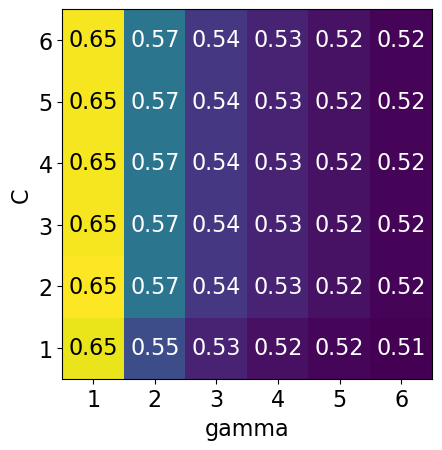

In [30]:
display_heatmap(param_grid, pipe_svm, X_train, y_train)

### <font color='red'>Question 3</font>

Based on this heat map, do you think we should try higher or lower values of C, to improve our results? What about gamma?

It turns out that our original choice of range for C and gamma was not a good one. The changes are too small to tell us anything interesting, and we are likely to have missed the best values combination.

To improve our search, we will test a different set of values, much more different from each other. This will allow us to get more different results and hopefully get closer to the right combination, while limiting the number of attempts (remember that trying each combination takes time).

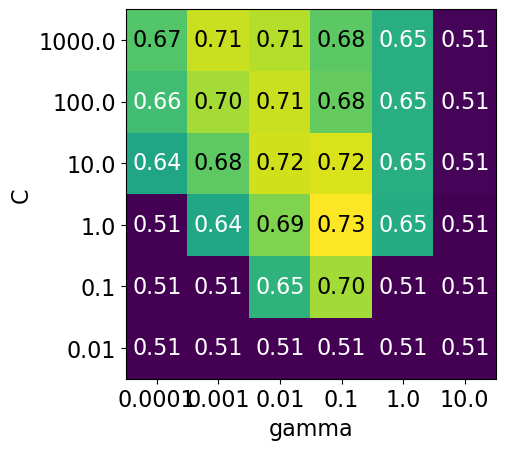

In [ ]:
param_grid1 = {
    "svc__gamma": 10.0**np.arange(-4, 2, 1), 
    "svc__C": 10.0**np.arange(-2, 4, 1)
}
display_heatmap(param_grid1, pipe_svm, X_train, y_train)

### <font color='red'>Question 4</font>

Do you think that this heat map includes in its range the right combination of C and gamma? What are the best values found so far?
> the best values are gamma = 0.1 and C = 1 with a score of 0.73
> is it the right combination? Yes

### <font color='red'>Question 5</font>

As next step, you may try to "zoom in" closer to the good values found in the previous step, to see if they can be improved further. We know that the best hyperparameters are in this area, and it would be pointless to explore other regions of the map.

Create a new parameter grid to explore new values in the region of interest. Please note that the grid needs to be 6x6 to work with the heat map function. You may enter your values manually, or try some useful functions to generate them, like `linspace()` and `logspace()` (examples below).

In [40]:
np.logspace(0.01, 1, 6)

array([ 1.02329299,  1.61435856,  2.54683025,  4.01790811,  6.33869711,
       10.        ])

In [37]:
np.linspace(1, 100, 6)

array([  1. ,  20.8,  40.6,  60.4,  80.2, 100. ])

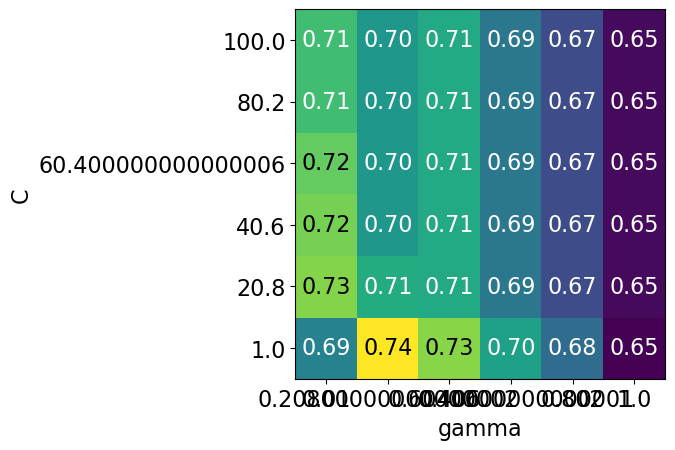

In [41]:
param_grid2 = {
    "svc__gamma": np.linspace(0.01, 1, 6),
    "svc__C": np.linspace(1, 100, 6)
}

display_heatmap(param_grid2, pipe_svm, X_train, y_train)

### <font color='red'>Question 6</font>

The function `display_heatmap()` is useful for visualization, but unfortunately does not save the resulting parameters and model. For that, you will need to run `GridSearchCV`, or, if you know exactly what parameters you want for your model, create a new pipeline with the new parameters. 

Do either of these steps, then compare the validation score to the one obtained with defalut values. Were we able to improve the model?

In [50]:
gs = GridSearchCV(pipe_svm, 
                  param_grid = param_grid2, 
                  n_jobs=-1, 
                  return_train_score=True
                 )

gs.fit(X_train, y_train)
gs.best_score_, gs.best_params_

(0.7439340038074727, {'svc__C': 1.0, 'svc__gamma': 0.20800000000000002})

### <font color='red'>Question 7</font>

Without counting our first wrong attempt at grid search (the one with the small range), we tried 72 combinations before settling on the best hyperparameters we could find. As the number of possible hyperparameters increases, grid search can start taking a lot of time!

Alternatively, we can use randomized search to test random combination of values within an interval. This is not as exhaustive as grid search, but it may still yield good results in a smaller amount of time. The cell below shows how to use `RandomizedSearchCV` to tune hyperparameters. 

We also added a new parameter: the `max_features` used by `CountVectorizer`. But this will not change the number of combinations tried (50, as per the parameter `n_iter`).

- What are the best hyperparameters according to `RandomizedSearchCV`? How does this model compare to the one found using grid search?
- Was it useful to try different values for `max_features`?
- (Optional, but interesting) why are we using `loguniform` to specify the range for C and gamma, instead of specific values or a uniform distribution?

In [51]:
from scipy.stats import loguniform, randint, uniform

param_dist = {
    "columntransformer__countvectorizer__max_features": [50, 100, 200, 400, 800, 1000, 2000],
    "svc__C": loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-5, 1e3),
}

In [58]:
from sklearn.model_selection import RandomizedSearchCV

# Create a random search object
random_search = RandomizedSearchCV(pipe_svm,                                    
                  param_distributions = param_dist, 
                  n_iter=50, 
                  n_jobs=-1, 
                  return_train_score=True)

# Carry out the search
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['acousticness',
                                                                                'danceability',
                                                                                'energy',
                                                                                'instrumentalness',
                                                                                'liveness',
                                                                                'loudness',
                                                                                'speechiness',
                                                                                'tempo',
                                                                                'valence']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['time_signature',
                                                                                'key']),
                                                                              ('passthrough',
                                                                               'pass...
                                                                               'song_title')])),
                                             ('svc', SVC())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'columntransformer__countvectorizer__max_features': [50,
                                                                                             100,
                                                                                             200,
                                                                                             400,
                                                                                             800,
                                                                                             1000,
                                                                                             2000],
                                        'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31b32b470>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31ce4f830>},
                   return_train_score=True)

In [59]:
random_search.best_score_

0.7420744957021711

In [60]:
random_search.best_params_

{'columntransformer__countvectorizer__max_features': 1000,
 'svc__C': 1.8565932563942824,
 'svc__gamma': 0.11036681133635777}

### <font color='red'>Question 8</font>

As always, our last step should be retraining the best model on the whole training set, and score it on the test set. Luckily for us, `GridSearchCV` and `RandomizedSearchCV` also fit a new model on the whole training set with the parameters that yielded the best results, so that is already taken care of!

Pick you preferred model and score it on the test set. How well does the test score hold up compared to the validation score?

In [62]:
random_search.score(X_test, y_test), gs.score(X_test, y_test)

(0.7574257425742574, 0.754950495049505)